In [1]:
import pandas as pd
import pickle
import random

import numpy as np
import torch
#import ninja
from backend.disentangle_concepts import *
import dnnlib 
import legacy

%load_ext autoreload
%autoreload 2

annotations_file = './data/annotated_files/seeds0000-50000.pkl'
with open(annotations_file, 'rb') as f:
    annotations = pickle.load(f)

ann_df = pd.read_csv('./data/annotated_files/sim_seeds0000-50000.csv')
concepts = './data/concepts.txt'

with open(concepts) as f:
    labels = [line.strip() for line in f.readlines()]

with dnnlib.util.open_url('./data/model_files/network-snapshot-010600.pkl') as f:
    model = legacy.load_network_pkl(f)['G_ema'].to('cpu') # type: ignore


/Users/ludovicaschaerf/anaconda3/envs/art-reco_x86/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ludovicaschaerf/anaconda3/envs/art-reco_x86/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ludovicaschaerf/anaconda3/envs/ar

In [2]:
concept_id = 'Abstract'
separation_vector, number_important_features, important_nodes, accuracy_sep = get_separation_space(concept_id, annotations, ann_df, method='LR', samples=150, C=0.1, latent_space='W')

Val performance logistic regression 0.9666666666666667


In [3]:
separation_vector.shape

(1, 512)

In [4]:
# get_verification_score(concept_id, separation_vector, model, annotations)

In [5]:
print(number_important_features, important_nodes)

9 [  3  53 183 244 290 331 345 376 424]


torch.Size([1, 14, 512])


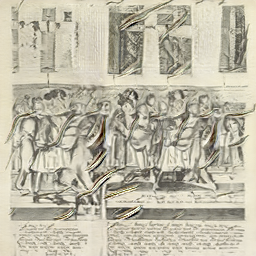

In [13]:
seed = random.randint(0,10000)
original_image_vec = annotations['w_vectors'][seed]
img = generate_original_image(original_image_vec, model, latent_space='W')
img

In [17]:
images, lambdas = regenerate_images(model, original_image_vec, separation_vector, min_epsilon=-(int(10)), max_epsilon=int(10), latent_space='W')

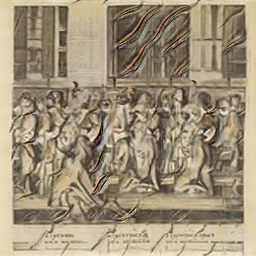

In [18]:
images[0]

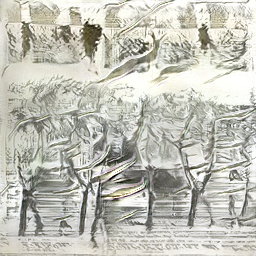

In [19]:
images[-1]

In [20]:
import open_clip
import os
import random
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = ""

model_clip, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='laion2b_s32b_b82k')
tokenizer = open_clip.get_tokenizer('ViT-L-14')

pre_prompt = "Artwork, " #@param {type:"string"}
text_descriptions = [f"{pre_prompt}{label}" for label in labels]
text_tokens = tokenizer(text_descriptions)

with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model_clip.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
text_features = text_features.cpu().numpy()
print(text_features.shape)



/Users/ludovicaschaerf/anaconda3/envs/art-reco_x86/lib/python3.8/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


(132, 768)


In [22]:
dic_clip_vecs = {l:v for l,v in zip(labels, text_features)}

In [26]:
dic_clip_vecs['Abstract'].shape
with open('data/CLIP_vecs.pkl', 'wb') as f:
    pickle.dump(dic_clip_vecs, f)

In [8]:
with open(annotations_file, 'rb') as f:
        annotations = pickle.load(f)
annotations['fname'][:10], annotations['z_vectors'][:1],# annotations['annotations'][:5]

(['/home/ludosc/data/stylegan-156000-captures/seed0000.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0001.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0002.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0003.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0004.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0005.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0006.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0007.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0008.png',
  '/home/ludosc/data/stylegan-156000-captures/seed0009.png'],
 [array([[ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
          -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
           0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
           0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
          -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
          -1.4

In [9]:
seed = random.randint(0,10000)
original_image_vec = annotations['z_vectors'][seed]
img = generate_original_image(original_image_vec, model)

In [10]:
concept_id = "Readymade"

Performance                 0.001932
Woodcut                     0.001960
Rural scene                 0.002205
Contemporary                0.003004
Individual                  0.003129
Oriental Eastern art        0.003205
Landscapes                  0.003367
Drawing                     0.004171
Lithography                 0.006614
Etching                     0.011107
People                      0.011938
Rocaille                    0.012255
Rococo                      0.014263
Renaissance                 0.018160
Representational            0.024860
Baroque                     0.027464
Ancient                     0.054892
Portrait                    0.087744
Regionalism                 0.683358
Unnamed: 0              10563.000000
Name: 10563, dtype: float64


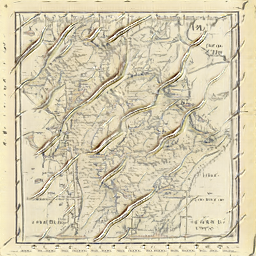

In [11]:
samples = 500 
abstracts = np.array([float(ann) for ann in ann_df[concept_id]])

repr_idxs = list(np.argsort(abstracts))[:samples]
abstract_idxs = list(np.argsort(abstracts))[-samples:]
    
z = annotations['z_vectors'][abstract_idxs[0]]
img = generate_original_image(z, model)
if 'ID' in ann_df.columns:
    ann_df = ann_df.drop('ID', axis=1)
print(ann_df.loc[abstract_idxs[0], :].sort_values()[-20:])
img

In [12]:
ann_df['Abstract'].value_counts()

2.700000e-08    10
2.400000e-08     9
5.500000e-08     9
3.600000e-08     9
1.700000e-08     9
                ..
2.006789e-03     1
1.055200e-05     1
3.565400e-05     1
3.154000e-06     1
3.812580e-04     1
Name: Abstract, Length: 13018, dtype: int64

Land Art           0.000000
Art Deco           0.000000
Art Nouveau        0.000000
Kinetic Art        0.000000
Warm palette       0.000000
                   ...     
Intaglio           0.000186
Lithography        0.000251
Etching            0.000369
Portrait           0.999049
Unnamed: 0      5064.000000
Name: 5064, Length: 133, dtype: float64


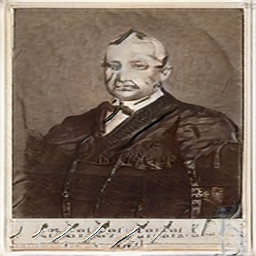

In [13]:
z = annotations['z_vectors'][repr_idxs[0]]
img = generate_original_image(z, model)
print(ann_df.loc[repr_idxs[0], :].sort_values())
img

In [14]:
for col in ann_df.columns:
    if '1' in col:
        print(col)

In [15]:
concepts = ['Op Art', 'Minimalism', 'Surrealism', 'Baroque', 'Lithography', 'Woodcut', 'Etching', 'Intaglio',]

vectors, nodes_in_common = get_concepts_vectors(concepts, annotations, ann_df, method='LR', samples=150, C=0.1)

Val performance logistic regression 0.8166666666666667
Val performance logistic regression 0.8333333333333334
Val performance logistic regression 0.6833333333333333
Val performance logistic regression 0.6333333333333333
Val performance logistic regression 0.9
Val performance logistic regression 0.7333333333333333
Val performance logistic regression 0.7166666666666667
Val performance logistic regression 0.6333333333333333


In [20]:
print(nodes_in_common)

set()


In [76]:
# import plotly.graph_objects as go

# # Generate example data
# x = projection[:, 0]  # x-coordinates of vectors
# y = projection[:, 1]  # y-coordinates of vectors
# z = projection[:, 2]  # z-coordinates of vectors
# data = []

# for i in range(len(x)):
#     # Create a 3D scatter plot
#     data.append(go.Scatter3d(
#         x=[0, x[i]],  # Start at x = 0
#         y=[0, y[i]],  # Start at y = 0
#         z=[0, z[i]],  # Start at z = 0
#         mode='lines',
#         marker=dict(size=5),
#         line=dict(width=2),
#         hovertext=concepts[i],
#         text=concepts[i],
#         name=concepts[i],
#         showlegend=True,
#     ))

# # layout = go.Layout(margin = dict( l = 0,
# #                                   r = 0,
# #                                   b = 0,
# #                                   t = 0)
# #                   )
# fig = go.Figure(data=data)
# # plot(fig,filename="vector.html",auto_open=False,image='png',image_height=800,image_width=1500)
# # # Set the title
# fig.update_layout(title='3D Vectors')
# # Set the axis labels
# fig.update_layout(scene=dict(
#     xaxis=dict(title='X', range=[-10, 10],),
#     yaxis=dict(title='Y', range=[-10, 10],),
#     zaxis=dict(title='Z', range=[-10, 10],),
# ))

# # Show the plot
# fig.show()


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

edges = []
for i in range(len(concepts)):
    for j in range(len(concepts)):
        if i != j:
            print(f'Similarity between {concepts[i]} and {concepts[j]}')
            similarity = cosine_similarity(vectors[i,:].reshape(1, -1), vectors[j,:].reshape(1, -1))
            print(np.round(similarity[0][0], 3))
            edges.append((concepts[i], concepts[j], np.round(similarity[0][0], 3)))


Similarity between Op Art and Minimalism
0.337
Similarity between Op Art and Surrealism
-0.168
Similarity between Op Art and Baroque
0.105
Similarity between Op Art and Lithography
0.233
Similarity between Op Art and Woodcut
0.302
Similarity between Op Art and Etching
0.324
Similarity between Op Art and Intaglio
0.341
Similarity between Minimalism and Op Art
0.337
Similarity between Minimalism and Surrealism
-0.013
Similarity between Minimalism and Baroque
0.167
Similarity between Minimalism and Lithography
0.403
Similarity between Minimalism and Woodcut
0.187
Similarity between Minimalism and Etching
0.35
Similarity between Minimalism and Intaglio
0.211
Similarity between Surrealism and Op Art
-0.168
Similarity between Surrealism and Minimalism
-0.013
Similarity between Surrealism and Baroque
0.127
Similarity between Surrealism and Lithography
-0.035
Similarity between Surrealism and Woodcut
-0.021
Similarity between Surrealism and Etching
-0.11
Similarity between Surrealism and Intag

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

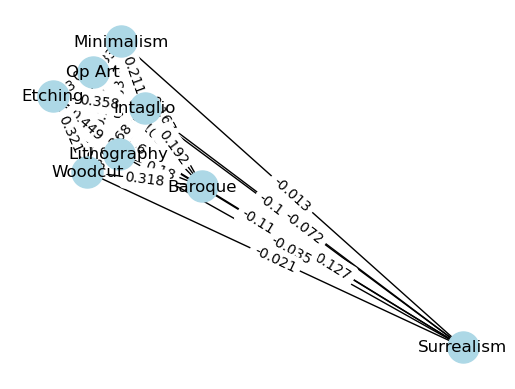

In [25]:
# Create an empty graph
G = nx.Graph()

# Add edges with weights to the graph
for edge in edges:
    node1, node2, weight = edge
    G.add_edge(node1, node2, weight=weight)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12)

# Draw edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Display the graph interactively
plt.axis('off')
plt.show()

In [26]:
import nxviz as nv


/Users/ludovicaschaerf/anaconda3/envs/art-reco_x86/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [27]:
from pyvis.network import Network

In [ ]:
net = Network(notebook=True, height="750px", width="100%",)
for e in edges:
    src = e[0]
    dst = e[1]
    w = e[2]

    net.add_node(src, src, title=src)
    net.add_node(dst, dst, title=dst)
    net.add_edge(src, dst, value=w, title=src + ' to ' + dst + ' similarity ' +str(w))
print(net)

# neighbor_map = net.get_adj_list()

# # add neighbor data to node hover data
# for node in net.nodes:
#     node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
#     node["value"] = len(neighbor_map[node["id"]])


# net.toggle_physics(True)
net.show('nx.html')

In [29]:
# seed = random.randint(0,10000)
# original_image_vec = annotations['z_vectors'][seed]
# img = generate_original_image(original_image_vec, model)

In [105]:
# z_0 = original_image_vec + 2 * vectors[0] + 2 * vectors[1]
        

In [30]:
# img = model(z_0.to(), None, truncation_psi=0.7, noise_mode='const')
# img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        

In [31]:
with dnnlib.util.open_url('./data/model_files/network-snapshot-010600.pkl') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to('cpu') # type: ignore

In [34]:
print(G)

Generator(
  (synthesis): SynthesisNetwork(
    w_dim=512, num_ws=14, img_resolution=256, img_channels=3, num_fp16_res=4
    (b4): SynthesisBlock(
      resolution=4, architecture=skip
      (conv1): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=4, up=1, activation=lrelu
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
      (torgb): ToRGBLayer(
        in_channels=512, out_channels=3, w_dim=512
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
    )
    (b8): SynthesisBlock(
      resolution=8, architecture=skip
      (conv0): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=8, up=2, activation=lrelu
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
      (conv1): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=8, up=1, activation=lrelu
 

In [45]:
print(G.mapping)

512


In [55]:
W = G.mapping(z, None, truncation_psi=0.7)

In [92]:
print(G.mapping(z, None, truncation_psi=1).shape)

torch.Size([1, 14, 512])


In [93]:
print(G.synthesis(W, noise_mode='const').shape)

torch.Size([1, 3, 256, 256])


In [99]:
seed = random.randint(0, 1000000)
W_0 = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to('cpu')
W = W_0.repeat([1, G.num_ws, 1])
img = G.synthesis(W, noise_mode='random')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
im = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
im.show()

In [101]:
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to('cpu')
W = G.mapping(z, None, truncation_psi=1)
print(W[0, 0] == W[0, 1])
img = G.synthesis(W, noise_mode='random')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
im = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
im.show()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [105]:
W[:,0,:,].shape

torch.Size([1, 512])

In [106]:
z.shape

torch.Size([1, 512])

In [107]:
z_vals = []
w_vals = []
fnames = []
# Generate images.
seeds = range(100)
for seed_idx, seed in enumerate(seeds):
    print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim))
    z_vals.append(z)
    z = z.to('cpu')
    fnames.append(f'data/images/seed{seed:04d}.png')
    # Construct an inverse rotation/translation matrix and pass to the generator.  The
    # generator expects this matrix as an inverse to avoid potentially failing numerical
    # operations in the network.
    # if hasattr(G.synthesis, 'input'):
    #     m = make_transform(translate, rotate)
    #     m = np.linalg.inv(m)
    #     G.synthesis.input.transform.copy_(torch.from_numpy(m))
    W = G.mapping(z, None, truncation_psi=1)
    w_vals.append(W[:,0,:])
    img = G.synthesis(W, noise_mode='const')

    #img = G(z, None, truncation_psi=0.7, noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'data/images/seed{seed:04d}.png')
    
info = {'fname': fnames, 'z_vectors': z_vals, 'w_vectors': w_vals}
with open(f'data/images/seeds{seeds[0]:04d}-{seeds[-1]:04d}.pkl', 'wb') as f:
    pickle.dump(info, f)


Generating image for seed 0 (0/100) ...
Generating image for seed 1 (1/100) ...
Generating image for seed 2 (2/100) ...
Generating image for seed 3 (3/100) ...
Generating image for seed 4 (4/100) ...
Generating image for seed 5 (5/100) ...
Generating image for seed 6 (6/100) ...
Generating image for seed 7 (7/100) ...
Generating image for seed 8 (8/100) ...
Generating image for seed 9 (9/100) ...
Generating image for seed 10 (10/100) ...
Generating image for seed 11 (11/100) ...
Generating image for seed 12 (12/100) ...
Generating image for seed 13 (13/100) ...
Generating image for seed 14 (14/100) ...
Generating image for seed 15 (15/100) ...
Generating image for seed 16 (16/100) ...
Generating image for seed 17 (17/100) ...
Generating image for seed 18 (18/100) ...
Generating image for seed 19 (19/100) ...
Generating image for seed 20 (20/100) ...
Generating image for seed 21 (21/100) ...
Generating image for seed 22 (22/100) ...
Generating image for seed 23 (23/100) ...
Generating i

In [ ]:
# import open_clip
# from open_clip import tokenizer

In [ ]:
# model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s34b_b88k')
# print(model.eval())
# context_length = model.context_length
# vocab_size = model.vocab_size


In [4]:
import rdflib
import csv

# Load the RDF file
rdf_file = '/Users/ludovicaschaerf/Desktop/Vase data/Getty vases.rdf'
graph = rdflib.Graph()
graph.parse(rdf_file)

# Specify the desired CSV file path
csv_file = '/Users/ludovicaschaerf/Desktop/Vase data/Getty vases.csv'
print(len(graph))

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#gYear, Converter=<function parse_date at 0x7f8f90926dc0>
Traceback (most recent call last):
  File "/Users/ludovicaschaerf/anaconda3/envs/art-reco_x86/lib/python3.8/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/Users/ludovicaschaerf/anaconda3/envs/art-reco_x86/lib/python3.8/site-packages/isodate/isodates.py", line 203, in parse_date
    raise ISO8601Error('Unrecognised ISO 8601 date format: %r' % datestring)
isodate.isoerror.ISO8601Error: Unrecognised ISO 8601 date format: '-0360'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#gYear, Converter=<function parse_date at 0x7f8f90926dc0>
Traceback (most recent call last):
  File "/Users/ludovicaschaerf/anaconda3/envs/art-reco_x86/lib/python3.8/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_

120874


In [6]:
print(len(graph))

120874


In [7]:
# Open the CSV file in write mode
with open(csv_file, 'w', newline='', encoding='utf-8') as file:

    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['Subject', 'Predicate', 'Object'])

    # Iterate over each triple in the RDF graph
    for subject, predicate, obj in graph:

        # Convert the triple components to strings
        subject_str = str(subject)
        predicate_str = str(predicate)
        object_str = str(obj)

        # Write the triple as a row in the CSV file
        writer.writerow([subject_str, predicate_str, object_str])

print('Conversion completed successfully!')


Conversion completed successfully!


In [10]:
import pandas as pd
final_file = pd.read_csv(csv_file)
final_file

Subject  \
0       https://www.getty.edu/art/collection/objects/2...   
1                       Na2bcd76068bb49a4a5514ea06a5ddb26   
2       https://media.getty.edu/iiif/image/3112300e-06...   
3                       N2b132be4c32949de86262a3816f7d2e0   
4                       Nbd3b44a61adf4891a77e551455838182   
...                                                   ...   
120869                  N9178d9a3793741438342ba4dd1a47615   
120870                  Nb3ae7c5b51bd4ed4bfa87166845303b3   
120871  https://www.getty.edu/art/collection/objects/9...   
120872  https://www.getty.edu/art/collection/objects/1...   
120873                  Ne1392870564845ca948b6dab33b2f283   

                                                Predicate  \
0       http://www.cidoc-crm.org/cidoc-crm/P43_has_dim...   
1        http://www.cidoc-crm.org/cidoc-crm/P90_has_value   
2                         http://purl.org/dc/terms/format   
3         http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
4         http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
...                                                   ...   
120869     http://www.cidoc-crm.org/cidoc-crm/P2_has_type   
120870    http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
120871  http://www.cidoc-crm.org/cidoc-crm/P50_has_cur...   
120872  http://www.cidoc-crm.org/cidoc-crm/P45_consist...   
120873     http://www.cidoc-crm.org/cidoc-crm/P2_has_type   

                                                   Object  
0                       Ne019ecf405544c0b9acf72080557b714  
1                                                     4.3  
2                                              image/jpeg  
3       http://www.cidoc-crm.org/cidoc-crm/E33_E41_Lin...  
4       http://www.cidoc-crm.org/cidoc-crm/E12_Production  
...                                                   ...  
120869               http://vocab.getty.edu/aat/300055647  
120870   http://www.cidoc-crm.org/cidoc-crm/E54_Dimension  
120871              http://kerameikos.org/id/getty_museum  
120872                 http://kerameikos.org/id/alabaster  
120873               http://vocab.getty.edu/aat/300055644  

[120874 rows x 3 columns]

In [11]:
vases = pd.read_csv('/Users/ludovicaschaerf/Desktop/Vase data/oxford_vases_info.csv')
vases_links = vases['URI']
vases.head()

/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_56066/4145076846.py:1: DtypeWarning: Columns (14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  vases = pd.read_csv('/Users/ludovicaschaerf/Desktop/Vase data/oxford_vases_info.csv')


URI  Vase Number    Fabric  \
0  http://www.beazley.ox.ac.uk/record/AA1CD952-92...          1.0  ATHENIAN   
1  http://www.beazley.ox.ac.uk/record/85D73CAF-DC...          2.0  ATHENIAN   
2  http://www.beazley.ox.ac.uk/record/B7867649-B6...          3.0  ATHENIAN   
3  http://www.beazley.ox.ac.uk/record/64B75012-4B...          4.0  ATHENIAN   
4  http://www.beazley.ox.ac.uk/record/ED45A6A0-5C...          5.0  ATHENIAN   

      Technique Sub Technique               Shape Name             Provenance  \
0  BLACK-FIGURE           NaN            AMPHORA, NECK  ITALY, ETRURIA, VULCI   
1  BLACK-FIGURE           NaN  KRATER, COLUMN FRAGMENT  GREECE, ATHENS, AGORA   
2  BLACK-FIGURE           NaN            AMPHORA, NECK  ITALY, ETRURIA, VULCI   
3  BLACK-FIGURE           NaN            AMPHORA, NECK                    NaN   
4  BLACK-FIGURE           NaN            AMPHORA, NECK                    NaN   

           Date Inscriptions  \
0  -525 to -475          NaN   
1  -550 to -500          NaN   
2  -550 to -500          NaN   
3  -550 to -500          NaN   
4  -525 to -475          NaN   

                                       Attributed To  ...  \
0  CHIUSI P by KUNZE-GOTTE | LEAGROS GROUP by KUN...  ...   
1                                                NaN  ...   
2                                                NaN  ...   
3               <em>Near</em> MEDEA GROUP by UNKNOWN  ...   
4  ANTIMENEAN by KUNZE-GOTTE | DAYBREAK P by POUI...  ...   

   Technical Observations Image Credits  \
0                     NaN           NaN   
1                     NaN           NaN   
2                     NaN           NaN   
3                     NaN           NaN   
4                     NaN           NaN   

                              Pleiades URI   Latitude  Longitude  LIMC ID  \
0  https://pleiades.stoa.org/places/413393  42.421429  11.702499     6368   
1                                      NaN        NaN        NaN      NaN   
2  https://pleiades.stoa.org/places/413393  42.421429  11.702499     1023   
3                                      NaN        NaN        NaN     1009   
4                                      NaN        NaN        NaN    10571   

                                            LIMC Web  \
0  http://ark.dasch.swiss/ark:/72163/080e-73fdcff...   
1                                                NaN   
2  http://ark.dasch.swiss/ark:/72163/080e-73b1f46...   
3  http://ark.dasch.swiss/ark:/72163/080e-73b1c12...   
4  http://ark.dasch.swiss/ark:/72163/080e-74394cd...   

                                 British Museum Link  Ure Museum Link  \
0                                                NaN              NaN   
1                                                NaN              NaN   
2                                                NaN              NaN   
3                                                NaN              NaN   
4  https://www.britishmuseum.org/collection/objec...              NaN   

   Bryn Mawr College Link  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

[5 rows x 29 columns]

In [20]:
vases['Vase Number'].nunique(), vases.shape

(130518, (130520, 29))

In [21]:
vases = vases.groupby('Vase Number').first().reset_index()

In [17]:
from bs4 import BeautifulSoup
import requests
response = requests.get(vases_links[0])
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')
div = soup.find('div', class_='recordImage')
if div is not None:
    img = div.find('img')
    if img is not None:
        img_src = img['src']
        print("Image source:", img_src)
    else:
        print("No image found inside the div.")
else:
    print("Div not found.")

Image source: /Vases/SPIFF/IMAGES200/GER37/CVA.GER37.1830.2/bc001001.jpe


In [23]:
import os
# Specify the folder path to save the images
folder_path = '/Users/ludovicaschaerf/Desktop/Vase data/images'

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

In [25]:
from tqdm import tqdm

In [ ]:
for uri,i in tqdm(zip(vases['URI'], vases['Vase Number'])):
    if i > 473:
        response = requests.get(uri)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')
        div = soup.find('div', class_='recordImage')
        if div is not None:
            img = div.find('img')
            if img is not None:
                img_src = 'https://www.carc.ox.ac.uk/' + img['src']
                print("Image source:", img_src)
            else:
                print("No image found inside the div.", i)
                continue
        else:
            print("Div not found.", i)
            continue
        # Specify the path to save the image
        save_path = os.path.join(folder_path, str(i) + '.jpg')

        # Download the image and save it to the specified path
        response = requests.get(img_src)
        if response.status_code == 200:
            with open(save_path, 'wb') as file:
                file.write(response.content)
            print("Image downloaded successfully.")
        else:
            print("Failed to download the image.")
            continue